<a href="https://colab.research.google.com/github/ffelicioni/tm-tp/blob/master/notebooks/analisis_prediccion_kats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
!pip install pystan==2.19.1.1
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cmdstanpy-1.0.7-py3-none-any.whl (80 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.7 which is incompatible.


In [34]:
!pip install --upgrade pip
#!pip install kats==0.1 ax-platform==0.2.3 statsmodels==0.12.2

!pip install kats==0.2 ax-platform==0.2.4 statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1 requires cmdstanpy>=1.0.1, but you have cmdstanpy 0.9.5 which is incompatible.


Librería https://facebookresearch.github.io/Kats/

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd

#from prophet import Prophet

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np


from kats.models.prophet import ProphetModel, ProphetParams
from kats.consts import TimeSeriesData
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.detectors.seasonality import FFTDetector
from kats.detectors.seasonality import ACFDetector
from kats.detectors.outlier import OutlierDetector
from kats.detectors.cusum_detection import CUSUMDetector
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

In [36]:
DATASET_PATH= 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/consumo_energetico_diario.csv'

In [37]:
dataset = pd.read_csv(DATASET_PATH,parse_dates=['dia'])
dataset.columns = dataset.columns.str.lower()

dataset.rename(columns={'dia':'time','mwh':'value'},inplace=True)
#df = df.rename(columns={"Hour Index": "time", "Users": "value"})
ts = TimeSeriesData(dataset[['time','value']])

dataset.head()

,time,value,tmp
0,2005-12-01,81445.928,18.104167
1,2005-12-02,81749.888,17.904167
2,2005-12-03,72134.590,19.562500
3,2005-12-04,63452.628,18.854167
4,2005-12-05,81508.078,21.941667


In [38]:
tiempo_ini='12-31-2001' #serie completa
#tiempo_ini='12-31-2011'

In [39]:
train_set=dataset[(dataset.time>tiempo_ini)&(dataset.time<'1-1-2020')] #ultimo dia train 31/12/2019, 
train_set.reset_index(inplace=True)

test_set=dataset[(dataset.time>='1-1-2020')] #ultimo dia train 31/12/2019
test_set.reset_index(inplace=True)

N_test=len(test_set)

ts = TimeSeriesData(train_set[['time','value']])

## Análisis

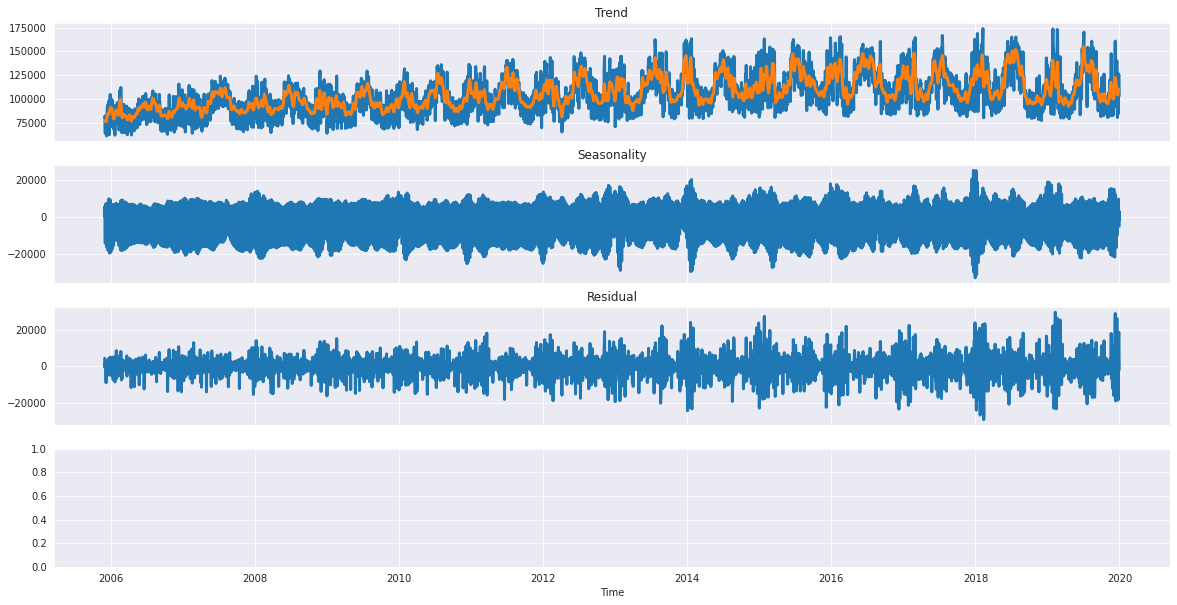

In [40]:
decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

In [41]:
fft_detector = FFTDetector(ts)
fft_detector.detector()

{'seasonality_presence': True,
 'seasonalities': [367.4285714285714, 6.998639455782313]}

In [42]:
fft_detector.plot(time_unit='day')  #time_unit – string containing the unit of time 

segun FFF exhibe estacionalidad. Los picos seleccionados son anual (1/0.00272=367 dias)y semanal (1/0.1428=6.99 dias). 

In [43]:
# This method runs acf and returns if seasonality detected in the given time series and potential cycle lengths
acf_detector = ACFDetector(ts)
acf_detector.detector()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



{'seasonality_presence': True, 'seasonalities': [7]}

estacionalidad por Autocorrelación -> semanal

## Outliers

In [44]:
#fig = px.line(train_set, x="time", y="value")
#fig

In [45]:
outlier_detector = OutlierDetector(ts, "additive")

outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[]

No encuentra ouliers

In [46]:
ts_day_outliers_interpolated = outlier_detector.remover(interpolate=True)

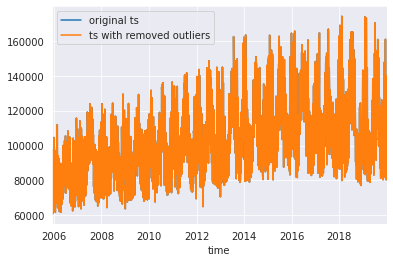

In [47]:
ax = ts.to_dataframe().plot(x="time", y="value")
ts_day_outliers_interpolated.to_dataframe().plot(x="time", y="y_0", ax=ax)
plt.legend(labels=["original ts", "ts with removed outliers"])
plt.show()

[CUSUMChangePoint(start_time: 2012-06-03 00:00:00, end_time: 2012-06-03 00:00:00, confidence: 1.0, direction: increase, index: 2376, delta: 18727.57525303887, regression_detected: True, stable_changepoint: True, mu0: 96366.26222381153, mu1: 115093.8374768504, llr: 1316.8576221899043, llr_int: inf, p_value: 0.0, p_value_int: nan)]


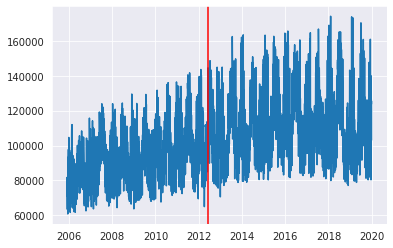

In [48]:
#CUSUM stands for cumulative sum, it is a changepoint detection algorithm
# este es un analisis univariado
cumsum_detector = CUSUMDetector(ts)
changepoints = cumsum_detector.detector()
print(changepoints)
# Plot
cumsum_detector.plot(changepoints)

Esta función ubica el punto de cambio (iteratively estimates the means
before and after the change point and finds the change point maximizing/minimizing the cusum value until the change point has converged). Luego aplica el test de hipótesis (null hypothesis has no change point with one mean and the alternative hypothesis has a change point with two means).

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



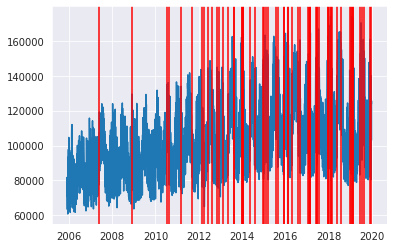

In [49]:
bocpd_detector = BOCPDetector(ts) # it tells us when the time series shows a change

changepoints = bocpd_detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, changepoint_prior=0.01
)
#for changepoint in changepoints:
#    print(changepoint[0])
    
# Plot
bocpd_detector.plot(changepoints)

**Ojo este análisis es solo con la serie univariada**: Given an univariate time series, this class performs changepoint detection, i.e. it tells us when the time series shows a change. This is online, which means it gives the best estimate based on a lookehead number of time steps (which is the lag).

## Predicción Prophet de kats

Predicción usando solo la variable a predecir

In [50]:
from kats.models.prophet import ProphetModel, ProphetParams

# Specify parameters
params = ProphetParams(seasonality_mode="additive")

# Create a model instance
model = ProphetModel(ts, params)

# Fit mode
model.fit()

# Forecast
forecast = model.predict(steps=N_test,freq='D')#, freq="MS")# es para meses

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


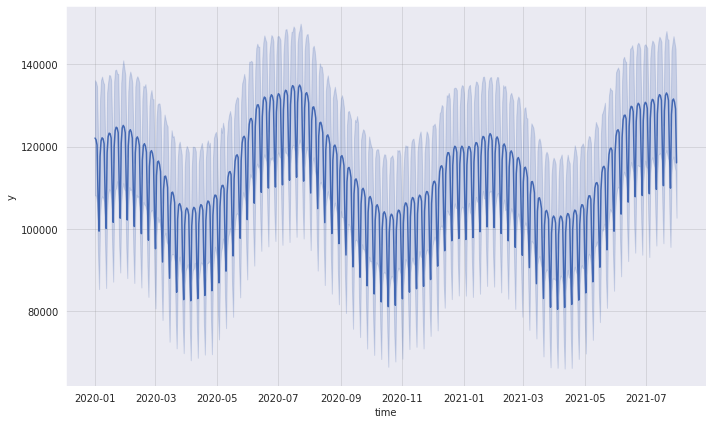

In [51]:
model.plot()

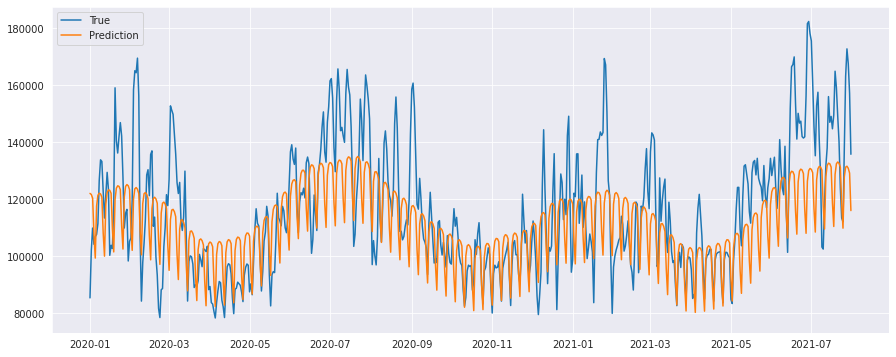

In [52]:
N=len(forecast)
y_fore=forecast['fcst']
y_fore_future=pd.DataFrame(y_fore)


plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
plt.plot(test_set.time,test_set.value,label="True")
plt.plot(test_set.time,y_fore_future, label="Prediction")
plt.legend()

In [53]:
mse = mean_squared_error(test_set.value, y_fore_future)
mae = mean_absolute_error(test_set.value, y_fore_future)
mape = mean_absolute_percentage_error(test_set.value, y_fore_future)
print('Test - Error cuadratico medio: ', mse)
print('Test - Error absoluto medio: ',mae)
print('Test - Error porcentual abs:',mape)

Test - Error cuadratico medio:  288847014.4248185
Test - Error absoluto medio:  13233.123917481495
Test - Error porcentual abs: 0.1093131521221404


#### Agrego regresor (temperatura)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


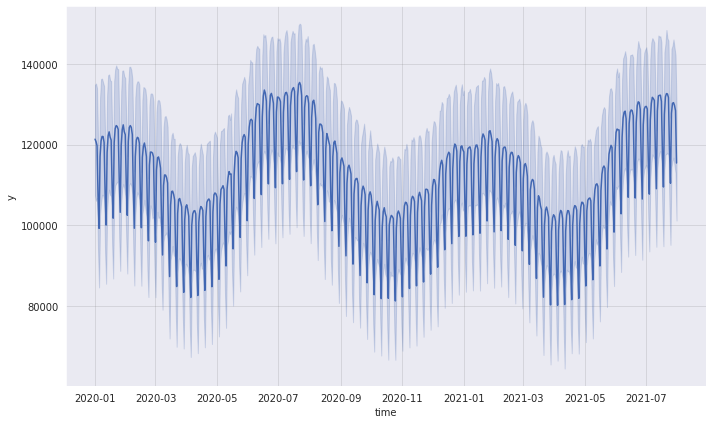

In [54]:
from kats.models.prophet import ProphetModel, ProphetParams
temperatura = pd.DataFrame(train_set[['time','tmp']])
temperatura_future = pd.DataFrame(test_set[['time','tmp']])

reg = pd.Series(temperatura.tmp)

pparams = ProphetParams(extra_regressors = [{'value': reg, 'name':'reg1'}])

pmodel = ProphetModel(data=ts, params=pparams)

pmodel.fit()

forecast = pmodel.predict(steps=N_test,freq='D', extra_regressors = [{'value': temperatura_future.tmp,'name':'reg1'}])

pmodel.plot()

Test - Error cuadratico medio:  292727754.79167813
Test - Error absoluto medio:  13259.780648102898
Test - Error porcentual abs: 0.10906698571927066


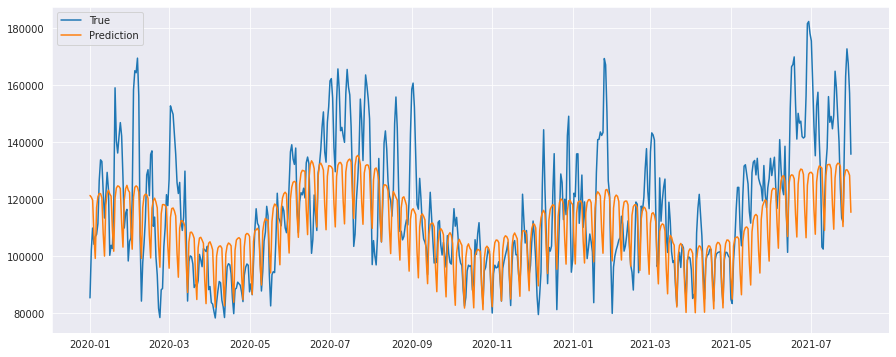

In [55]:
N=len(forecast)
y_fore=forecast['fcst']
y_fore_future=pd.DataFrame(y_fore)


plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
plt.plot(test_set.time,test_set.value,label="True")
plt.plot(test_set.time,y_fore_future, label="Prediction")
plt.legend()

mse = mean_squared_error(test_set.value, y_fore_future)
mae = mean_absolute_error(test_set.value, y_fore_future)
mape = mean_absolute_percentage_error(test_set.value, y_fore_future)
print('Test - Error cuadratico medio: ', mse)
print('Test - Error absoluto medio: ',mae)
print('Test - Error porcentual abs:',mape)

#### Agrego regresor abs(temperatura-18°C)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


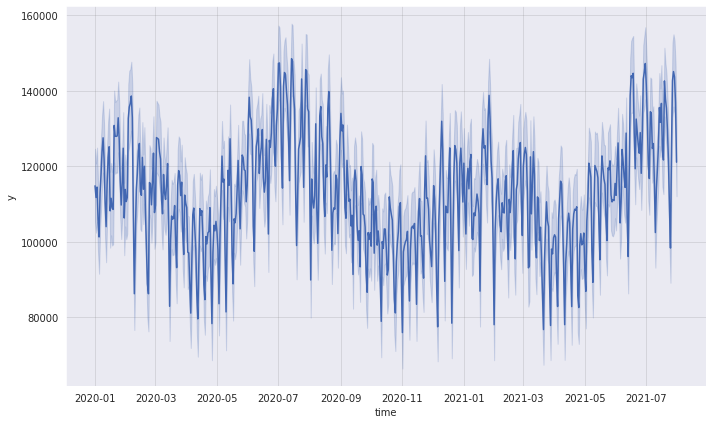

In [56]:

temperatura = pd.DataFrame(train_set[['time','tmp']])
temperatura.tmp=np.abs(temperatura.tmp-18)
temperatura_future = pd.DataFrame(test_set[['time','tmp']])
temperatura_future.tmp=np.abs(temperatura_future.tmp-18)

reg = pd.Series(temperatura.tmp)

pparams = ProphetParams(extra_regressors = [{'value': reg, 'name':'reg1'}])

pmodel = ProphetModel(data=ts, params=pparams)

pmodel.fit()

forecast = pmodel.predict(steps=N_test,freq='D', extra_regressors = [{'value': temperatura_future.tmp,'name':'reg1'}])

pmodel.plot()

Test - Error cuadratico medio:  137584018.1238095
Test - Error absoluto medio:  9089.431347676076
Test - Error porcentual abs: 0.0750770649917519


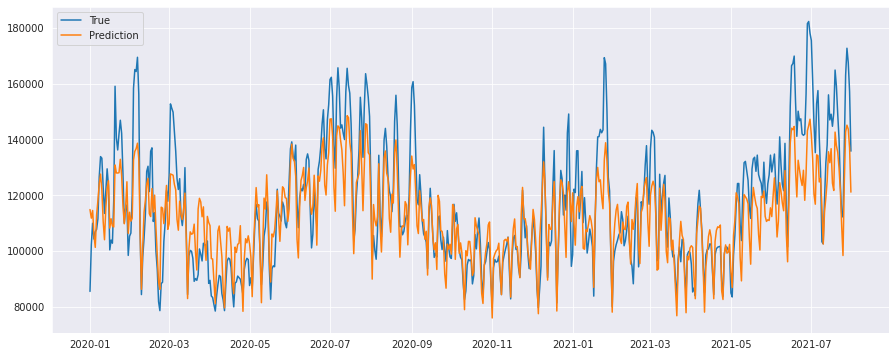

In [57]:
N=len(forecast)
y_fore=forecast['fcst']
y_fore_future=pd.DataFrame(y_fore)


plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
plt.plot(test_set.time,test_set.value,label="True")
plt.plot(test_set.time,y_fore_future, label="Prediction")
plt.legend()

mse = mean_squared_error(test_set.value, y_fore_future)
mae = mean_absolute_error(test_set.value, y_fore_future)
mape = mean_absolute_percentage_error(test_set.value, y_fore_future)
print('Test - Error cuadratico medio: ', mse)
print('Test - Error absoluto medio: ',mae)
print('Test - Error porcentual abs:',mape)

### SARIMA - pendiente

Solo uso la serie despues del cambio detectado

In [58]:
train_set2=dataset[(dataset.time>'2012-06-03')&(dataset.time<'1-1-2020')] #ultimo dia train 31/12/2019, 
train_set2.reset_index(inplace=True)

ts2 = TimeSeriesData(train_set2[['time','value']])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



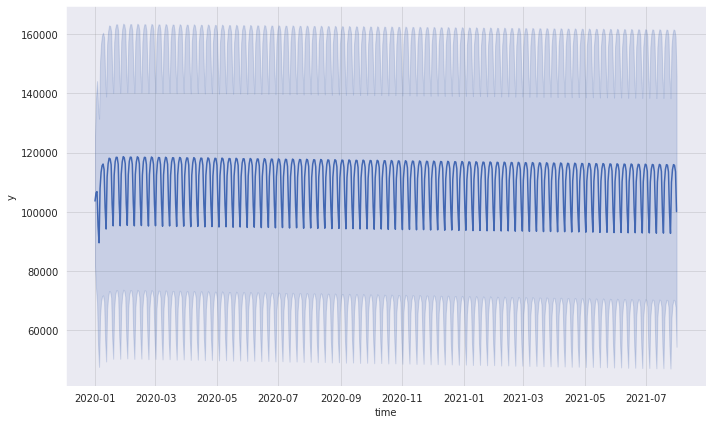

In [59]:
from kats.models.sarima import SARIMAModel, SARIMAParams
#warnings.simplefilter(action='ignore')

# create SARIMA param class
params = SARIMAParams(
    p = 2, #2
    d=0, 
    q=2, #2 
    trend = 'c', 
    seasonal_order=(0,1,1,7) #0,1,1,7
    )

# initiate SARIMA model
m = SARIMAModel(data=ts2, params=params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=N_test, 
    freq="D"
    )

# make plot to visualize
m.plot()

Test - Error cuadratico medio:  504738646.9729777
Test - Error absoluto medio:  18153.650410483897
Test - Error porcentual abs: 0.15067127121245372


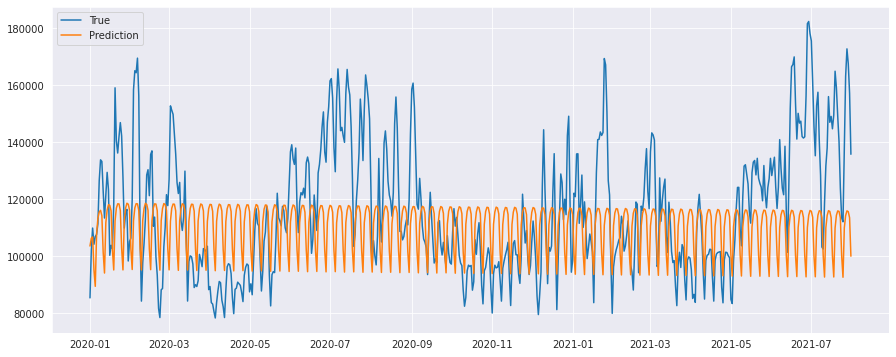

In [60]:
y_fore=fcst['fcst']
y_fore_future=pd.DataFrame(y_fore)


plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
plt.plot(test_set.time,test_set.value,label="True")
plt.plot(test_set.time,y_fore_future, label="Prediction")
plt.legend()

mse = mean_squared_error(test_set.value, y_fore_future)
mae = mean_absolute_error(test_set.value, y_fore_future)
mape = mean_absolute_percentage_error(test_set.value, y_fore_future)
print('Test - Error cuadratico medio: ', mse)
print('Test - Error absoluto medio: ',mae)
print('Test - Error porcentual abs:',mape)